<a href="https://colab.research.google.com/github/fabianobarreto350-gif/MVPML/blob/main/MVP_ML_Fabiano_Barreto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MVP: *Machine Learning & Analytics*



*   Autor: Fabiano Humberto Duarte Barreto
*   Data: 28/09/2025




*  Matrícula: 4052025001285
*   Dataset: https://raw.githubusercontent.com/fabianobarreto350-gif/MVPML/refs/heads/main/logistics_shipments_dataset.csv




**1. Escopo, objetivo e definição do problema**



*   Contexto do problema e objetivo: previsão da quantidade de dias de atraso de entrega de mercadorias. A empresa na qual trabalho realiza operações de importação de insumos para suprir as necessidades do setor produtivo dentro dos prazos estabelecidos pelo departamento de produção. O modelo de previsão ajudaria no gerenciamento dos prazos para evitar interrupções do parque fabril e, consequentemente, prejuízos financeiros.
*   Tipo de tarefa: regressão


*   Área de aplicação: dados tabulares
*   Valor para o negócio/usuário: o modelo de previsão pode ajudar evitar ou minimizar impactos no setor produtivo. Sabendo que a importação de um insumo pode atrasar uma determinada quantidade de dias, o setor produtivo pode se reorganizar para evitar uma paralisação e, assim, não precisar pagar multas por descumprimento das metas diárias de produção perante o contrato com os clientes.





**2. Reprodutibilidade e ambiente**


*   Bibliotecas usadas;
*   Seeds fixas para reprodutibilidade



In [1]:
import os, random, time, sys, math
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score,
                             silhouette_score)

from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint, uniform

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

**2.1 Funções**


*   Definição de função para métricas de avaliação para problemas de regressão






In [2]:
def evaluate_regression(y_true, y_pred):
    """Evaluates regression model performance."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}


**3. Dados: carga, entendimento, qualidade e verificações iniciais**


*   Origem dos dados: como não tive autorização para usar dados da minha empresa, procurei uma base no Kaggle que fosse próxima da realidade das rotinas de importação da minha empresa, com informações contendo origem e destino, data do embarque e data da entrega, distância, tempo de deslocamento, status de cada entrega e empresa transportadora. A base de dados conta com 2000 registros simulando operações de carregamento e entrega de mercadorias. O dataset conta com:
     - features categóricas: Origin_Warehouse, Destination, Carrier, Shipment_Date, Delivery_Date,  Status (Delivered, Delayed, In Transit, Returned, Lost);
     - features numéricas: Weight_KG, Cost, Distance_miles, Transit_Days;
     - por fim, a base tem 2% de valores faltantes.




In [3]:
#importação do dataset

url_dataset = 'https://raw.githubusercontent.com/fabianobarreto350-gif/MVPML/refs/heads/main/logistics_shipments_dataset.csv'
df = pd.read_csv(url_dataset)
df.head()

,Shipment_ID,Origin_Warehouse,Destination,Carrier,Shipment_Date,Delivery_Date,Weight_kg,Cost,Status,Distance_miles,Transit_Days
0,SH10000,Warehouse_MIA,San Francisco,UPS,2023-10-02,2023-10-04,25.7,67.46,Delivered,291,2
1,SH10001,Warehouse_MIA,Atlanta,DHL,2023-12-06,2023-12-09,38.9,268.85,Delivered,1225,3
2,SH10002,Warehouse_LA,Houston,DHL,2023-09-18,2023-09-20,37.2,74.35,Delivered,220,2
3,SH10003,Warehouse_BOS,Seattle,OnTrac,2023-01-26,2023-02-04,42.6,187.04,Delivered,1156,9
4,SH10004,Warehouse_SF,Dallas,OnTrac,2023-06-03,2023-06-06,7.9,120.01,Delivered,1017,3


In [4]:
#Verificação inicial das condições e tipo de cada feature.

display(df.info())
print('\nValores ausentes por coluna:')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Shipment_ID       2000 non-null   object 
 1   Origin_Warehouse  2000 non-null   object 
 2   Destination       2000 non-null   object 
 3   Carrier           2000 non-null   object 
 4   Shipment_Date     2000 non-null   object 
 5   Delivery_Date     1968 non-null   object 
 6   Weight_kg         2000 non-null   float64
 7   Cost              1959 non-null   float64
 8   Status            2000 non-null   object 
 9   Distance_miles    2000 non-null   int64  
 10  Transit_Days      2000 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 172.0+ KB


None


Valores ausentes por coluna:
Shipment_ID          0
Origin_Warehouse     0
Destination          0
Carrier              0
Shipment_Date        0
Delivery_Date       32
Weight_kg            0
Cost                41
Status               0
Distance_miles       0
Transit_Days         0
dtype: int64


**3.1.1 Análise exploratória resumida (EDA)**


*   Verificação da proporção dos Status. Objetivo é saber se há uma quantidade significativa de eventos logísticos realizados com atrasos e os que foram realizados dentro do prazo.



In [5]:

print(df['Status'].value_counts())
print(df['Status'].value_counts(normalize=True).map('{:.2%}'.format))


Status
Delivered     1648
Delayed        199
In Transit      76
Lost            45
Returned        32
Name: count, dtype: int64
Status
Delivered     82.40%
Delayed        9.95%
In Transit     3.80%
Lost           2.25%
Returned       1.60%
Name: proportion, dtype: object


**3.1.2 Análise exploratória resumida (EDA)**


*   Histograma numérico
*   Distribuição dos Status por empresa responsável pela logística (Carrier)


*   Análise de correlação entre as features numéricas






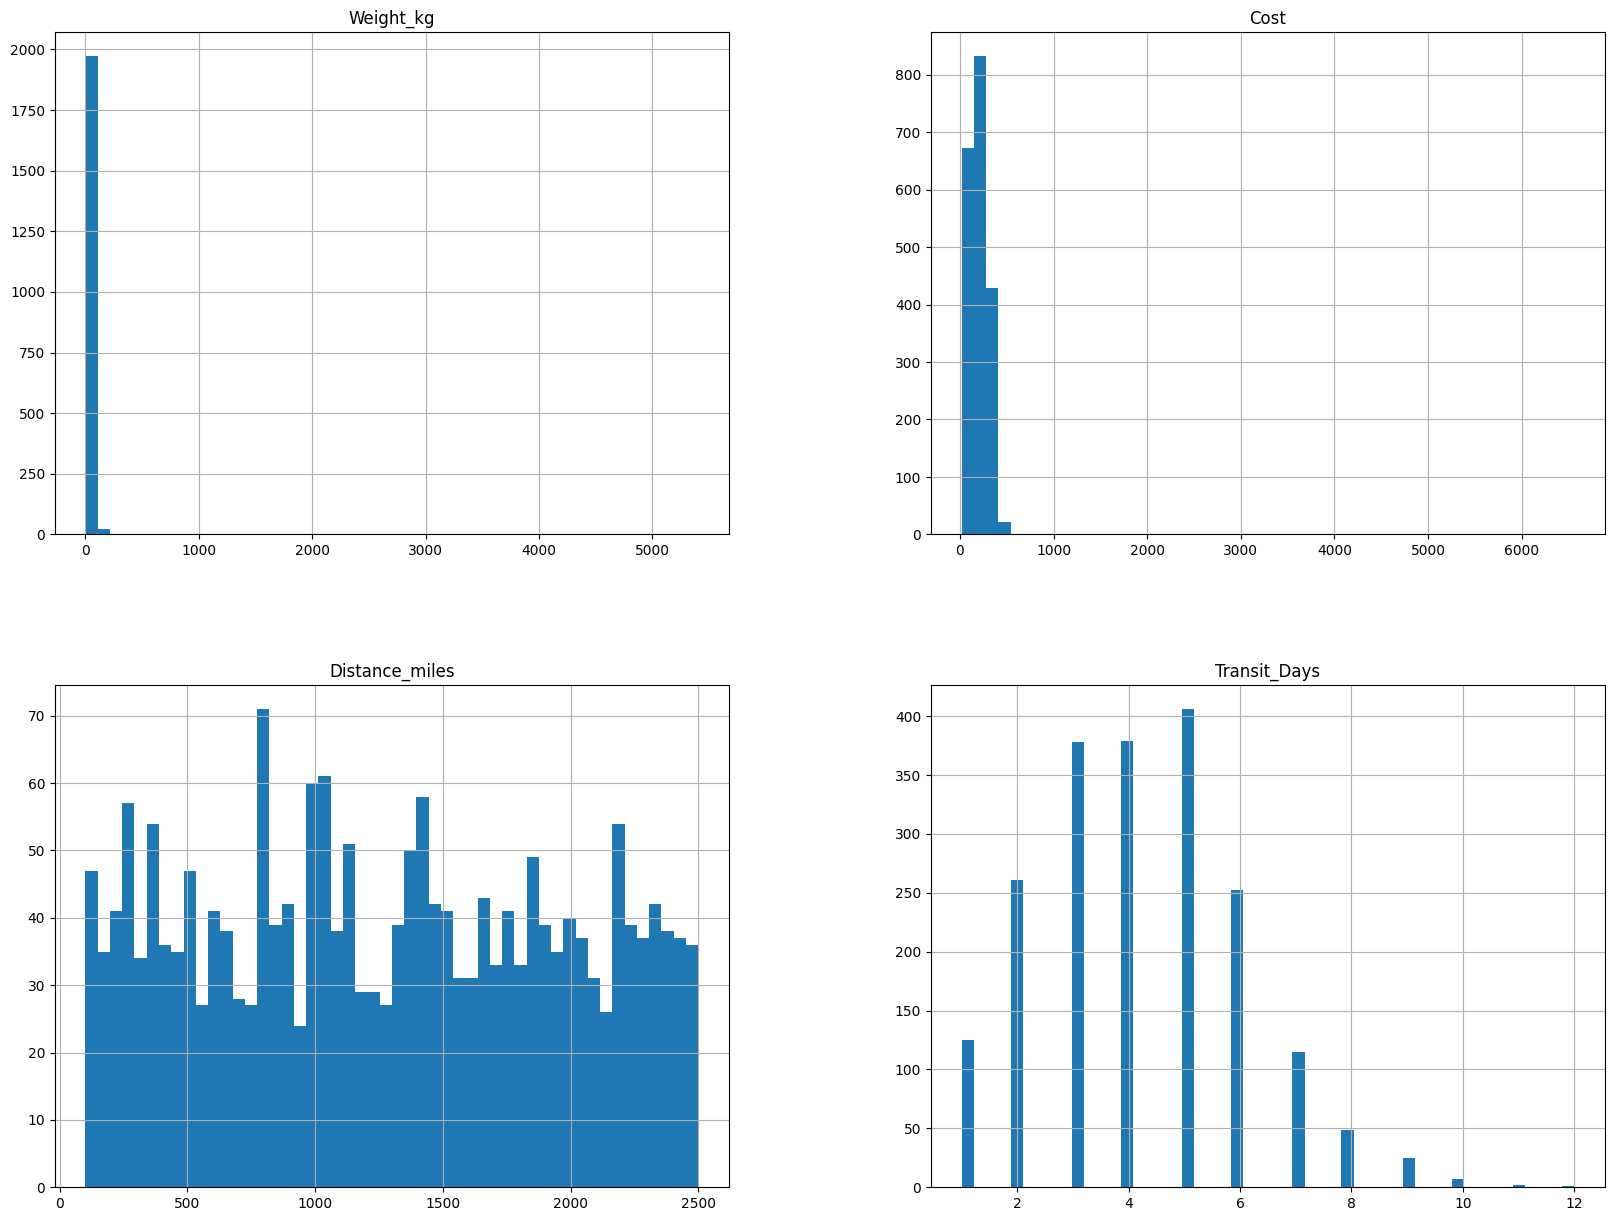

In [6]:
#Histograma numérico
df.hist(bins=50, figsize=(20,15))
plt.show()


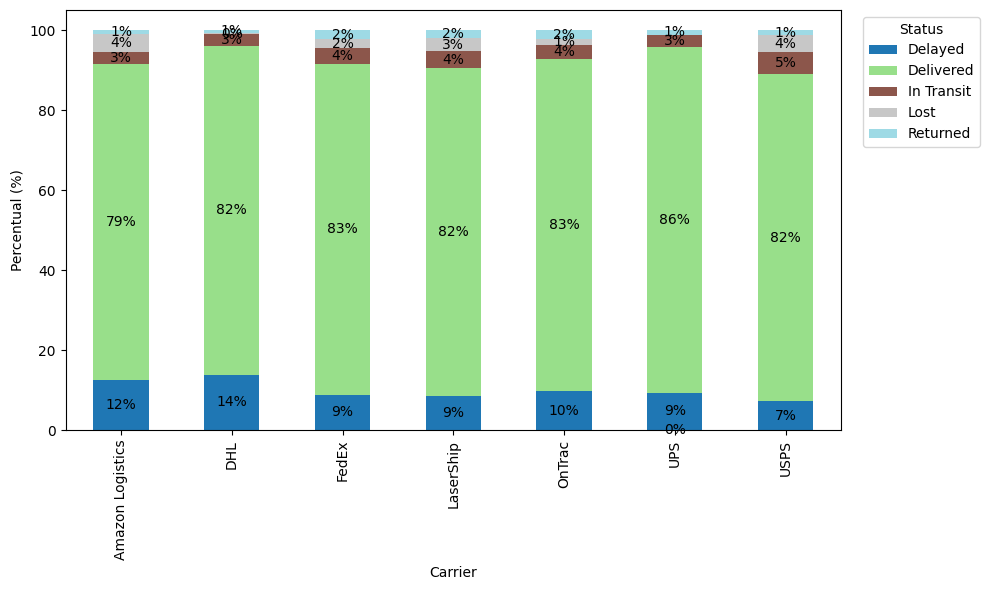

In [7]:
#Carrier x Status
ct = df.groupby(['Carrier', 'Status']).size().unstack(fill_value=0)

# Percentual por linha (cada Carrier soma 100%)
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

ax = ct_pct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.xticks(rotation=90)
plt.xlabel('Carrier')
plt.ylabel('Percentual (%)')
plt.legend(title='Status', bbox_to_anchor=(1.02, 1), loc='upper left')

# Adicionar rótulos de porcentagem em cada segmento
for container in ax.containers:  # cada cor/coluna empilhada
    # fmt='%.0f%%' -> arredonda; '%.1f%%'
    ax.bar_label(container, fmt='%.0f%%', label_type='center', padding=0)

plt.tight_layout()
plt.show()

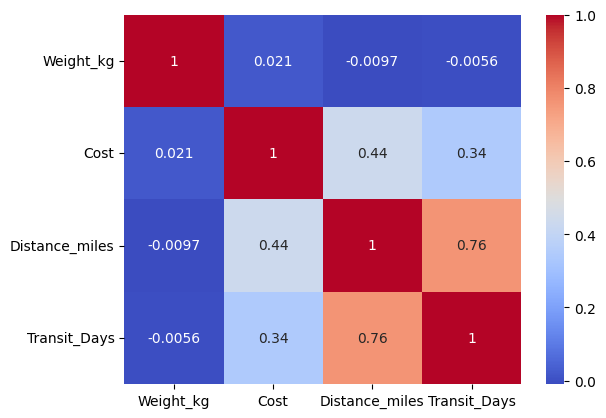

In [8]:
#Correlação

df_filtrado = df[['Weight_kg','Cost','Distance_miles','Transit_Days']]



sns.heatmap(df_filtrado.corr(), annot=True, cmap='coolwarm')
plt.show()

**3.1.3 Análise exploratória resumida (EDA) - Conclusões**


*   Após análise observa-se que as features Transit_Days X Distance_Miles possuem forte correlação (0.76), seguidas da correlação entre Distance_Miles X Cost (0.44), e por fim, Transit_Days X Cost (0.34).


*   Desta forma, são levantadas as seguintes hipóteses: quanto maior a distância maior a quantidade de dias de transporte e quanto maior a distância maior o custo. Portanto, Distance_Miles deve ser a feature preponderante para impactar na quantidade de dias de atraso das entregas das mercadorias.  



**4. Definição do Target, variáveis e divisão dos dados**


*   Como o ojetivo desse trabalho é ter um modelo de previsão da quantidade de dias de atraso, o Target escolhido é Transit_Days.


*   A feature Shipment_ID será excluída da base de dados pois não é relevante para o modelo de previsão.


*   Será adotado a proporção de 80% para treino e 20% para teste.







In [9]:
# Exclusão da feature Shipment_ID

df.drop(columns=['Shipment_ID'], inplace=True)


# Definição de features e target
PROBLEM_TYPE = "regressao"
if PROBLEM_TYPE == "regressao":
    TARGET = "Transit_Days"
    FEATURES = [c for c in df.columns if c != TARGET]
else:
    raise ValueError("PROBLEM_TYPE inválido.")

print("PROBLEM_TYPE:", PROBLEM_TYPE)
print("TARGET:", TARGET)
print("FEATURES:", FEATURES)

#divisão dos dados
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


PROBLEM_TYPE: regressao
TARGET: Transit_Days
FEATURES: ['Origin_Warehouse', 'Destination', 'Carrier', 'Shipment_Date', 'Delivery_Date', 'Weight_kg', 'Cost', 'Status', 'Distance_miles']
X_train: (1600, 9)
X_test: (400, 9)


**5. Tratamento de dados e Pipeline de pré-processamento**


*   Nessa etapa o objetivo é fazer um tratamento dos dados para imputação de valores faltantes, evitar data leakage e codificação one-hot. Valores numéricos ausentes serão preenchidos pela mediana e os valores categóricos ausentes serão preenchidos pelo valor que aparece com mais frequência (moda). Além disso, as categorias são transformadas em variáveis binárias (dummies). Isso permite trabalhar com uma base de treino 100% preenchida, organizada e padronizada.




In [10]:
#Tratamento e agrupamento das features numéricas e categóricas

num_cols = [c for c in X_train.columns if str(X_train[c].dtype) in ['int64', 'float64']]
cat_cols = [c for c in X_train.columns if str(X_train[c].dtype) in ['object', 'bool']]

#Tratamento das features numéricas. Imput seguindo a estratégia 'median' para valores ausentes.

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

#Tratamento das features categóricas. Imput seguindo a estratégia 'most_frequent' para valores ausentes e transformação em variáveis dummies.

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

#Transformação
preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])
print("num_cols:", num_cols)
print("cat_cols:", cat_cols)

num_cols: ['Weight_kg', 'Cost', 'Distance_miles']
cat_cols: ['Origin_Warehouse', 'Destination', 'Carrier', 'Shipment_Date', 'Delivery_Date', 'Status']


**6. Baseline e modelos candidatos**


*   Nesta etapa optou-se por uma baseline simples (DummyRegressor) pois é preciso criar uma linha de base, uma referência mínima de desempenho para comparar com os modelos mais robustos, e assim, verificar se o modelo supera ou não o DummyRegressor. A estratégia adotada é a "median" para amenizar a presença de outliers.
*   Para os modelos candidatos são utilizados os algoritmos de regressão para fins de comparação de desempenho.



In [11]:
#Definição do pipeline e um conjunto de candidatos.
#A ideia é padronizar o fluxo de dados com o mesmo preprocessamento e trocar apenas o modelo na etapa final. Isso facilita comparação justa entre modelos.

if PROBLEM_TYPE == "regressao":
    baseline = Pipeline(steps=[("pre", preprocess),
                               ("model", DummyRegressor(strategy="median"))])

    candidates = {
        "Ridge": Pipeline([("pre", preprocess), ("model", Ridge(random_state=SEED))]),
        "RandomForestReg": Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=SEED))]),
        "LinearRegression": Pipeline([("pre", preprocess), ("model", LinearRegression())]),
        "Lasso": Pipeline([("pre", preprocess), ("model", Lasso())]),
        "KNeighborsRegressor": Pipeline([("pre", preprocess), ("model", KNeighborsRegressor())]),
        "DecisionTreeRegressor": Pipeline([("pre", preprocess), ("model", DecisionTreeRegressor())]),
        "SVR": Pipeline([("pre", preprocess), ("model", SVR())])}




else:
  raise ValueError("PROBLEM_TYPE inválido.")

baseline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Weight_kg', 'Cost',
                                                   'Distance_miles']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Origin_Warehouse',
                                                   'Destination', 'Carrier',
                                                   'Shipment_Date',
                                                   'Delivery_Date',
                                                   'Status'])])),
                ('model', DummyRegressor(strategy='median'))])

**6.1 Treino e avaliação rápida (baseline vs candidatos)**

In [12]:
results = {}

if PROBLEM_TYPE in ["regressao"]:
    # Baseline
    t0 = time.time()
    baseline.fit(X_train, y_train)
    t1 = time.time()
    if PROBLEM_TYPE == "regressao":
    # Predição e avaliação no teste
        y_pred = baseline.predict(X_test)
        results["baseline"] = evaluate_regression(y_test, y_pred)
    else:
        raise ValueError("PROBLEM_TYPE inválido.")
    # Tempo de treino
    results["baseline"]["train_time_s"] = round(t1 - t0, 3)

    # Candidatos
    for name, pipe in candidates.items():
        t0 = time.time()
        pipe.fit(X_train, y_train)
        t1 = time.time()
        if PROBLEM_TYPE == "regressao":
            y_pred = pipe.predict(X_test)
            results[name] = evaluate_regression(y_test, y_pred)
        else:
             raise ValueError("PROBLEM_TYPE inválido.")
        results[name]["train_time_s"] = round(t1 - t0, 3)

    pd.DataFrame(results).T
    print(pd.DataFrame(results).T)

                            MAE       MSE      RMSE        R2  train_time_s
baseline               1.497500  3.542500  1.882153 -0.011711         0.051
Ridge                  1.071168  1.965094  1.401818  0.438784         0.031
RandomForestReg        0.956400  1.687238  1.298937  0.518138         6.412
LinearRegression       1.295992  3.072595  1.752882  0.122490         0.072
Lasso                  1.263800  2.533534  1.591708  0.276442         0.035
KNeighborsRegressor    1.003500  1.811900  1.346068  0.482535         0.019
DecisionTreeRegressor  1.200000  2.760000  1.661325  0.211765         0.165
SVR                    0.957409  1.734952  1.317176  0.504511         0.359


Principais conclusões


*   Baseline:

    - Tem R2 negativo (-0.0117) e maiores erros (RMSE 1.882), como esperado de um DummyRegressor. Serve como referência mínima.
- Melhores desempenhos (RMSE mais baixo / R2 mais alto):

   - RandomForestReg: RMSE 1.298 e R2 0.518 — melhor R2 do grupo; bom equilíbrio de erro e capacidade de generalização. Custo: treino mais lento (6.417 s).
   - SVR: RMSE 1.317 e R2 0.504 — desempenho próximo ao Random Forest, com tempo de treino moderado.
   - KNeighborsRegressor: RMSE 1.346 e R2 0.482 — bom desempenho, muito rápido.
- Modelos lineares:

   - Ridge: RMSE 1.402 e R2 0.439 — supera bem a baseline; regularização L2 ajuda.
   - LinearRegression: RMSE 1.753 e R2 0.122 — desempenho fraco; sugere colinearidade, falta de regularização ou relação não-linear entre features e alvo.
   - Lasso: RMSE 1.592 e R2 0.276 — melhor que LR simples, mas inferior ao Ridge, possivelmente por excesso de regularização L1 reduzindo demasiadamente os coeficientes.
- Árvore de decisão:

   - DecisionTreeRegressor: RMSE 1.661 e R2 0.212 — tende a overfitting se não bem regulada; desempenho inferior aos ensembles e kernels.
*   Trade-offs de desempenho vs tempo
    - Melhor resultado: RandomForestReg
    - Rapidez com desempenho razoável: KNeighborsRegressor ou Ridge
    - Interpretabilidade linear com boa generalização: Ridge é preferível ao LinearRegression e Lasso neste caso.



**7. Validação e Otimização de Hiperparâmetros**



*   Nesta etapa será aplicada a validação cruzada KFold para regressão, e, o modelo RandomForestReg, que obteve o melhor resultado conforme analisado na etapa anterior.




In [13]:
#Validação cruzada e otimização de hiperparâmetros
if PROBLEM_TYPE == "regressao":
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model = Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=SEED))])
    param_dist = {
        "model__n_estimators": randint(100, 400),
        "model__max_depth": randint(3, 20),
        "model__min_samples_split": randint(2, 10)
    }
    scorer = "neg_root_mean_squared_error"


    search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=cv, scoring=scorer, random_state=SEED, n_jobs=-1, verbose=1)
    search.fit(X_train, y_train)

    print("Melhor score (CV):", search.best_score_)
    print("Melhores parâmetros:", search.best_params_)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor score (CV): -1.2021352155477607
Melhores parâmetros: {'model__max_depth': 4, 'model__min_samples_split': 9, 'model__n_estimators': 376}


* Foi testado outras configurações de hiperparâmetros que pioraram CV. Optei por manter um tuning enxuto adequado a um dataset de 2000 linhas e 9 features preditoras.  
* Algumas configurações testadas:
  -  param_dist = {
    "model__n_estimators": randint(50, 200),
    "model__max_depth": randint(5, 25),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["sqrt", "log2"]}
    - param_dist = {
    "model__n_estimators": randint(50, 200),
    "model__max_depth": randint(5, 20),
    "model__min_samples_split": randint(2, 15),
    "model__min_samples_leaf": randint(1, 8),
    "model__max_features": ["sqrt", "log2"]}
    search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    **n_iter=30**

**8. Avaliação final, análise de erros e limitações**


In [14]:
#Teste
if PROBLEM_TYPE in ["regressao"] and 'search' in globals() and hasattr(search, "best_estimator_"):
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    if PROBLEM_TYPE == "regressao":
        print('Metricas para avaliar a regressão: ', evaluate_regression(y_test, y_pred))

Metricas para avaliar a regressão:  {'MAE': 0.9443826592311774, 'MSE': 1.535325236375827, 'RMSE': np.float64(1.2390824171038128), 'R2': 0.5615227825622059}


In [15]:
#comparando com baseline para verificar o ganho
y_pred_base = baseline.predict(X_test)
print("Baseline (teste):", evaluate_regression(y_test, y_pred_base))

Baseline (teste): {'MAE': 1.4975, 'MSE': 3.5425, 'RMSE': np.float64(1.8821530224718712), 'R2': -0.011711073309784048}


**9. Conclusões e análises**

- O RMSE de teste (1.2391) está próximo do RMSE da validação cruzada (1.2021). A diferença é pequena, indicando boa generalização e ausência de overfitting relevante.
- Comparando o teste com baseline há uma melhora absoluta de ~0.64 e relativa de ~34% - uma melhora significativa.
- R2 positivo de 0.56 significa que o modelo explica cerca de 56% da variância do alvo no conjunto de teste.

Com a adoção do algoritmo RandomForestReg, o modelo está capturando padrão real e generaliza razoavelmente bem. R2 de 56% é um resultado sólido e atenderia às necessidades do negócio. Ainda há espaço para melhorias, mas já é claramente melhor que o baseline.
Como possíveis próximos passos para tentar elevar o R2 seriam: ajuste fino do grid do RandomForest, explorar modelos alternativos como Gradient Boosting/HistGradientBoosting, validação de dados, entre outros.

Para concluir, esse projeto adotou técnicas visando garantir robustez dos resultados. Foram aplicadas seeds fixas, garantindo a reprodutibilidade; adoção de função, tornando o código limpo e organizado; descrição do contexto de negócio e do dataset; aplicação de análise exploratória, gerando gráficos ajudando na análise de correlação e levantamento de hipóteses; definição do target e aplicação da técnica de holdout; tratamento dos dados e criação de pipeline; estabelecimento de baseline para comparação com modelos candidatos; validação cruzada e ajuste de hiperparâmetros; por fim, comparação entre os resultados de teste com a validação cruzada e baseline.